In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/BP_data.csv
/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/SHEL_data.csv
/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/XOM_data.csv


In [2]:
import time
import warnings
import itertools
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from pandas.plotting import autocorrelation_plot, scatter_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error

<h2>About the dataset</h2>

This dataset provides a detailed view of how major energy companies' stock prices were influenced by the energy crises between 2021 and 2024. The data covers three prominent energy companies: ExxonMobil (XOM), Shell (SHEL), and BP (BP), with historical stock price information collected via the *yfinance* library. This dataset is particularly useful for those interested in financial analysis, market behavior, and the impact of global events on the energy sector.

**Start Date**: 2021-01-04 </br>
**End Date**: 2024-11-19

**Columns Descriptions**:</br>
<ul>
    <li>Date: The date of the stock data point.</li>
    <li>Open: The price at which the stock opened on a particular day.</li>
    <li>Close: The closing price of the stock for that day.</li>
    <li>High: The highest price of the stock for that day.</li>
    <li>Low: The lowest price of the stock for that day.</li>
    <li>Adj Close: The adjusted closing price, accounting for splits and dividends.</li>
    <li>Volume: The total number of shares traded during the day.</li>
</ul>

In [3]:
def sep(text, length = 30):
    print(length * '--')
    print(int((length - len(text))*0.5) * '  ' + text.upper())
    print(length * '--')

In [4]:
bp_df = pd.read_csv('/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/BP_data.csv', parse_dates = ['Date'])
shel_df = pd.read_csv('/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/SHEL_data.csv', parse_dates = ['Date'])
xom_df = pd.read_csv('/kaggle/input/energy-crisis-and-stock-price-dataset-2021-2024/XOM_data.csv', parse_dates = ['Date'])

In [5]:
bp_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
972,2024-11-13,28.139999,28.670000,27.820000,28.570000,28.570000,12243600
973,2024-11-14,28.889999,29.070000,28.760000,29.049999,29.049999,11091800
974,2024-11-15,29.100000,29.219999,28.830000,28.980000,28.980000,8120300
975,2024-11-18,29.299999,29.500000,29.240000,29.420000,29.420000,10184800
976,2024-11-19,28.980000,29.170000,28.889999,29.090000,29.090000,11686900


In [6]:
sep('BP')
display(bp_df.head())
sep('SHEL')
display(shel_df.head())
sep('XOM')
display(xom_df.head())

------------------------------------------------------------
                            BP
------------------------------------------------------------


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,21.090000,21.129999,20.549999,20.830000,17.184427,14485100
1,2021-01-05,21.430000,22.780001,21.370001,22.379999,18.463150,25447500
2,2021-01-06,23.370001,23.860001,22.940001,23.410000,19.312887,25221400
3,2021-01-07,23.719999,24.150000,23.500000,23.910000,19.725380,16470700
4,2021-01-08,24.170000,24.490000,23.990000,24.400000,20.129620,20189600


------------------------------------------------------------
                          SHEL
------------------------------------------------------------


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,36.250000,36.360001,35.494999,36.029999,31.140999,6794599
1,2021-01-05,37.189999,39.014999,37.115002,38.509998,33.284489,8518589
2,2021-01-06,39.910000,40.680000,39.564999,40.290001,34.822952,9180332
3,2021-01-07,40.000000,40.625000,39.744999,40.340000,34.866161,4829303
4,2021-01-08,40.360001,40.419998,39.770000,40.240002,34.779736,5546750


------------------------------------------------------------
                          XOM
------------------------------------------------------------


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,41.450001,42.250000,41.000000,41.500000,35.163219,27764700
1,2021-01-05,41.840000,44.799999,41.830002,43.500000,36.857830,44035100
2,2021-01-06,44.410000,45.099998,43.700001,44.610001,37.798344,36484800
3,2021-01-07,45.000000,45.570000,44.529999,44.959999,38.094898,29528100
4,2021-01-08,45.200001,45.820000,44.950001,45.459999,38.518559,28628200


In [7]:
sep('BP')
display(bp_df.info())
sep('SHEL')
display(shel_df.info())
sep('XOM')
display(xom_df.info())

------------------------------------------------------------
                            BP
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       977 non-null    datetime64[ns]
 1   Open       977 non-null    float64       
 2   High       977 non-null    float64       
 3   Low        977 non-null    float64       
 4   Close      977 non-null    float64       
 5   Adj Close  977 non-null    float64       
 6   Volume     977 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.6 KB


None

------------------------------------------------------------
                          SHEL
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       977 non-null    datetime64[ns]
 1   Open       977 non-null    float64       
 2   High       977 non-null    float64       
 3   Low        977 non-null    float64       
 4   Close      977 non-null    float64       
 5   Adj Close  977 non-null    float64       
 6   Volume     977 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.6 KB


None

------------------------------------------------------------
                          XOM
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       977 non-null    datetime64[ns]
 1   Open       977 non-null    float64       
 2   High       977 non-null    float64       
 3   Low        977 non-null    float64       
 4   Close      977 non-null    float64       
 5   Adj Close  977 non-null    float64       
 6   Volume     977 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.6 KB


None

<h2>EDA</h2>

<h3>Check missing values</h3>

The datasets have no missing values, as shown below:

In [8]:
def check_missing(df):
    df_name = [x for x in globals() if globals()[x] is df][0]
    nan = (100*df.isnull().sum() / len(df)).round(2)
    nan_Series = pd.Series(nan, name = f'{df_name.upper()} nan pct (%)')
    return nan_Series.sort_values(ascending = False)

sep('BP')
display(check_missing(bp_df))
sep('SHEL')
display(check_missing(shel_df))
sep('XOM')
display(check_missing(xom_df))

------------------------------------------------------------
                            BP
------------------------------------------------------------


Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
Name: BP_DF nan pct (%), dtype: float64

------------------------------------------------------------
                          SHEL
------------------------------------------------------------


Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
Name: SHEL_DF nan pct (%), dtype: float64

------------------------------------------------------------
                          XOM
------------------------------------------------------------


Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
Name: XOM_DF nan pct (%), dtype: float64

<h3>Check missing/Duplicate dates</h3>

The dataset has 439 missing dates, the same for all the three company stocks:

In [9]:
def check_missing_dates(df, start, end, freq):
    df_name = [x for x in globals() if globals()[x] is df][0]
    full_range = pd.date_range(start = start, end = end, freq = freq)
    missing_dates = full_range[~full_range.isin(df['Date'])]
    print(df_name.upper() + ' MISSING DATES:')
    print('No missing dates!') if len(missing_dates) == 0 else print(f'{len(missing_dates)} missing dates:\n{missing_dates}')
    return missing_dates

bp_missing_dates = check_missing_dates(bp_df, '2021-01-04', '2024-11-19', '1d')
shel_missing_dates = check_missing_dates(shel_df, '2021-01-04', '2024-11-19', '1d')
xom_missing_dates = check_missing_dates(xom_df, '2021-01-04', '2024-11-19', '1d')

BP_DF MISSING DATES:
439 missing dates:
DatetimeIndex(['2021-01-09', '2021-01-10', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-23', '2021-01-24', '2021-01-30',
               '2021-01-31', '2021-02-06',
               ...
               '2024-10-19', '2024-10-20', '2024-10-26', '2024-10-27',
               '2024-11-02', '2024-11-03', '2024-11-09', '2024-11-10',
               '2024-11-16', '2024-11-17'],
              dtype='datetime64[ns]', length=439, freq=None)
SHEL_DF MISSING DATES:
439 missing dates:
DatetimeIndex(['2021-01-09', '2021-01-10', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-23', '2021-01-24', '2021-01-30',
               '2021-01-31', '2021-02-06',
               ...
               '2024-10-19', '2024-10-20', '2024-10-26', '2024-10-27',
               '2024-11-02', '2024-11-03', '2024-11-09', '2024-11-10',
               '2024-11-16', '2024-11-17'],
              dtype='datetime64[ns]', length=439, freq=None)
XOM_DF MISSING D

No duplicate dates are detected:

In [10]:
def check_duplicate_dates(df):
    df_name = [x for x in globals() if globals()[x] is df][0]
    dates_vc = df['Date'].value_counts()
    duplicated_dates = dates_vc[dates_vc > 1]
    print(df_name.upper() + ' DUPLICATED DATES:')
    print('No duplicated dates!') if len(duplicated_dates) == 0 else print(f'{len(duplicated_dates)} duplicated dates:\n{duplicated_dates}')
    return duplicated_dates

sep('bp')
check_duplicate_dates(bp_df)
sep('shel')
check_duplicate_dates(shel_df)
sep('xom')
check_duplicate_dates(xom_df)

------------------------------------------------------------
                            BP
------------------------------------------------------------
BP_DF DUPLICATED DATES:
No duplicated dates!
------------------------------------------------------------
                          SHEL
------------------------------------------------------------
SHEL_DF DUPLICATED DATES:
No duplicated dates!
------------------------------------------------------------
                          XOM
------------------------------------------------------------
XOM_DF DUPLICATED DATES:
No duplicated dates!


Series([], Name: count, dtype: int64)

We reindex the dataframe to include the missing dates and plot the data to visualize their distribution:

In [11]:
if 'Date' in bp_df.columns:
    bp_df.set_index('Date', inplace = True)
    shel_df.set_index('Date', inplace = True)
    xom_df.set_index('Date', inplace = True)
    
    bp_df = bp_df.reindex(pd.date_range(start = '2021-01-04', end = '2024-11-19', freq = '1d'))
    shel_df = shel_df.reindex(pd.date_range(start = '2021-01-04', end = '2024-11-19', freq = '1d'))
    xom_df = xom_df.reindex(pd.date_range(start = '2021-01-04', end = '2024-11-19', freq = '1d'))
    print('Dataframes reindexed.')
    
missing_mask = np.where(np.isnan(bp_df['Open']))[0]

Dataframes reindexed.


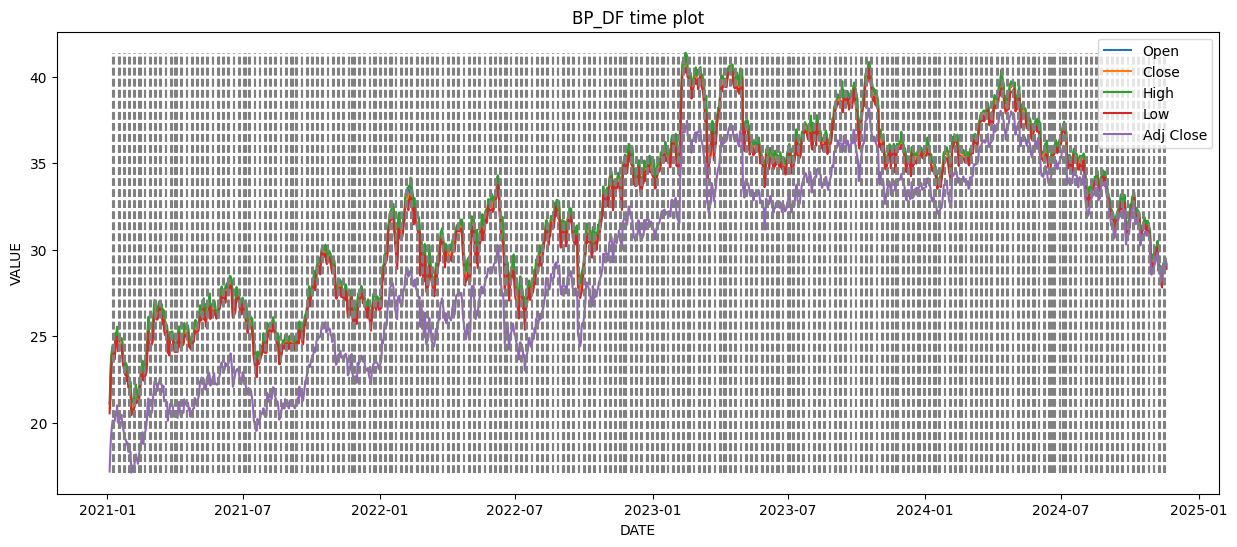

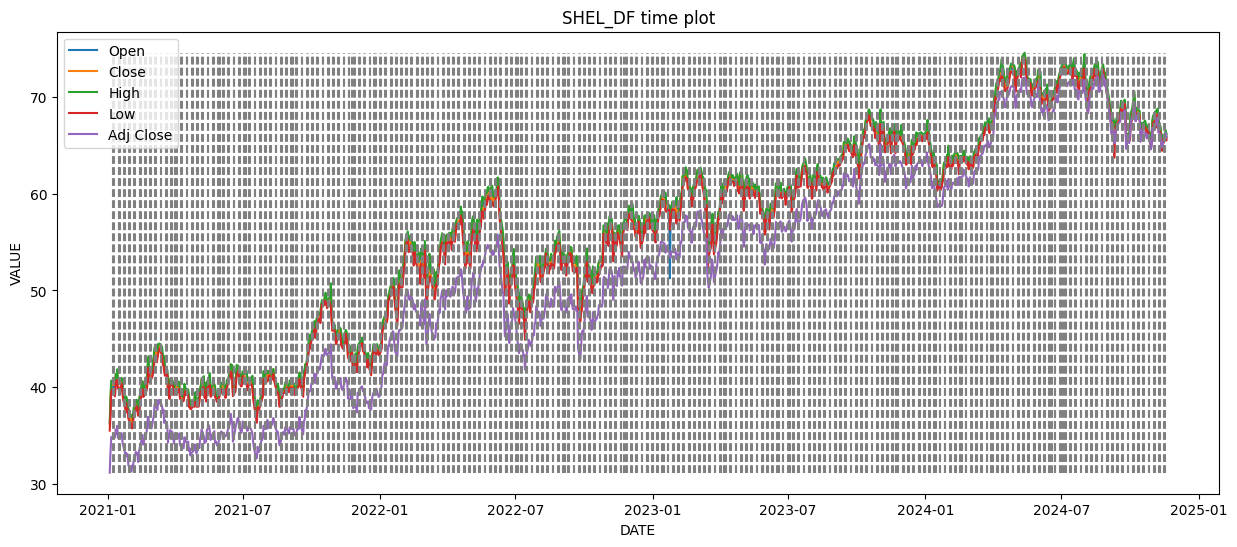

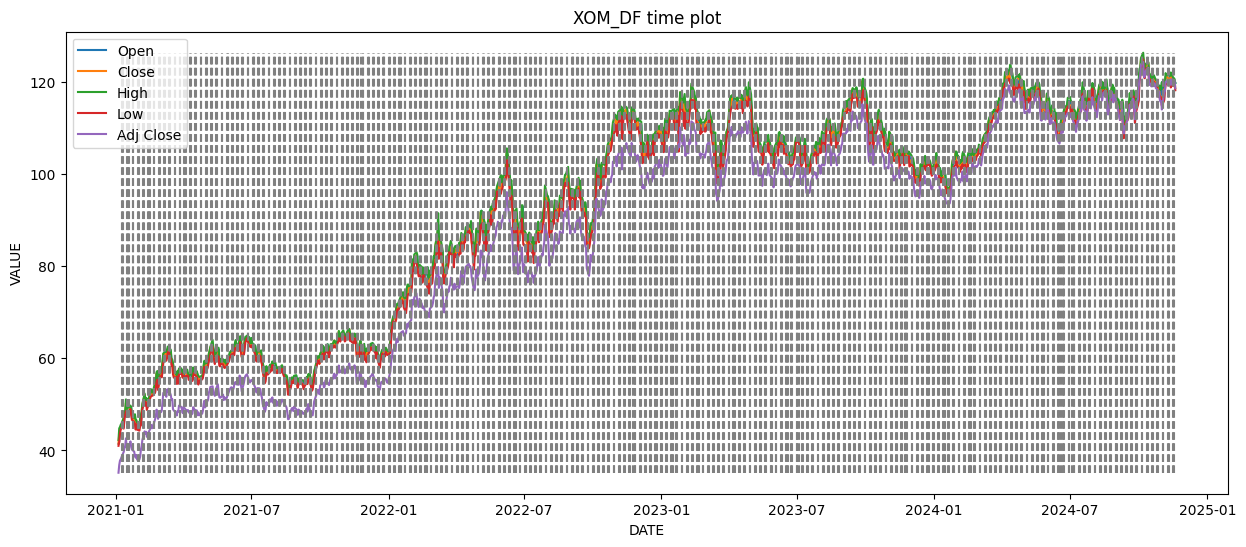

In [12]:
def plot_ts(df, cols = ['Open', 'Close', 'High', 'Low', 'Adj Close'], mask = None):
    df_name = [x for x in globals() if globals()[x] is df][0]
    _, ax = plt.subplots(figsize = (15,6))
    for col in cols:
        sns.lineplot(x = df.index, y = df[col], label = col, ax = ax)
    if mask is not None:
        plt.vlines(x = df.index[mask], ymin = min(df[cols].min()), ymax = max(df[cols].max()), color = 'gray', linestyle = '--')
    plt.title(f'{df_name.upper()} time plot')
    plt.xlabel('DATE')
    plt.ylabel('VALUE')
    plt.show()

plot_ts(bp_df, mask = missing_mask)
plot_ts(shel_df, mask = missing_mask)
plot_ts(xom_df, mask = missing_mask)

The missing date are evenly distributed in the data time span, therefore we're confident to interpolate without significant errors:

In [13]:
bp_filled = bp_df.interpolate(method = 'piecewise_polynomial')
shel_filled = shel_df.interpolate(method = 'piecewise_polynomial')
xom_filled = xom_df.interpolate(method = 'piecewise_polynomial')

print('BP nan: ', bp_filled.isnull().sum())
print('SHEL nan: ', shel_filled.isnull().sum())
print('XOM nan: ', xom_filled.isnull().sum())

BP nan:  Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
SHEL nan:  Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
XOM nan:  Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


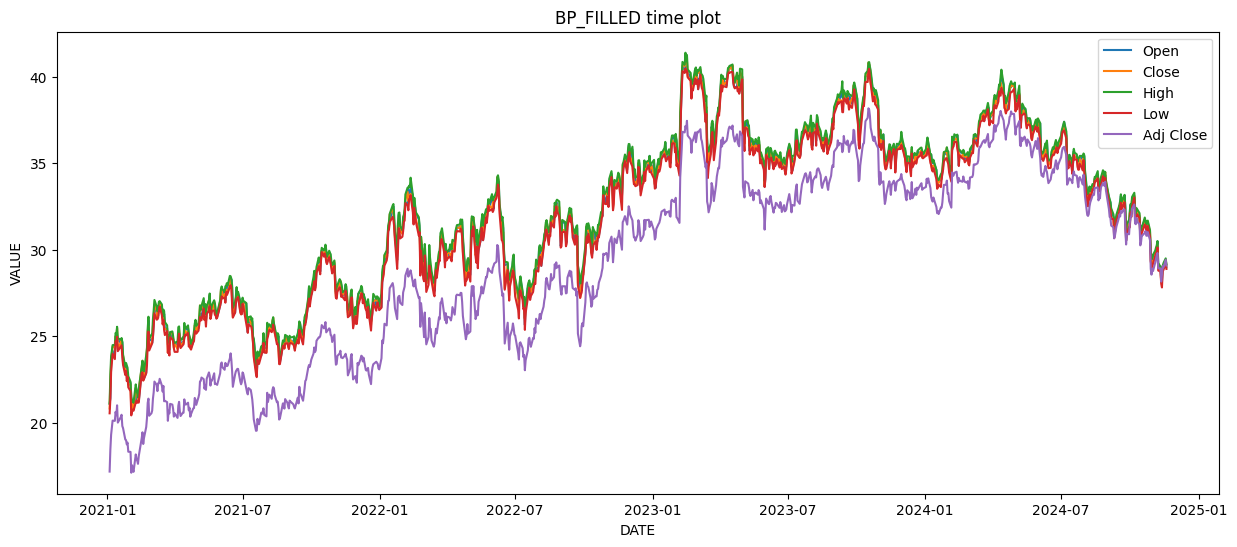

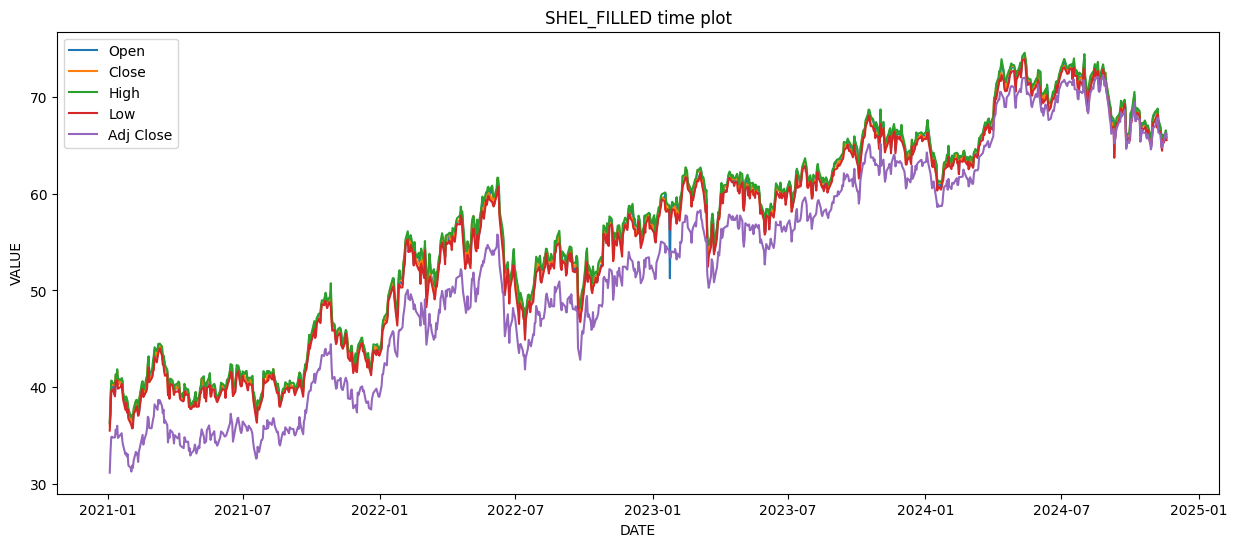

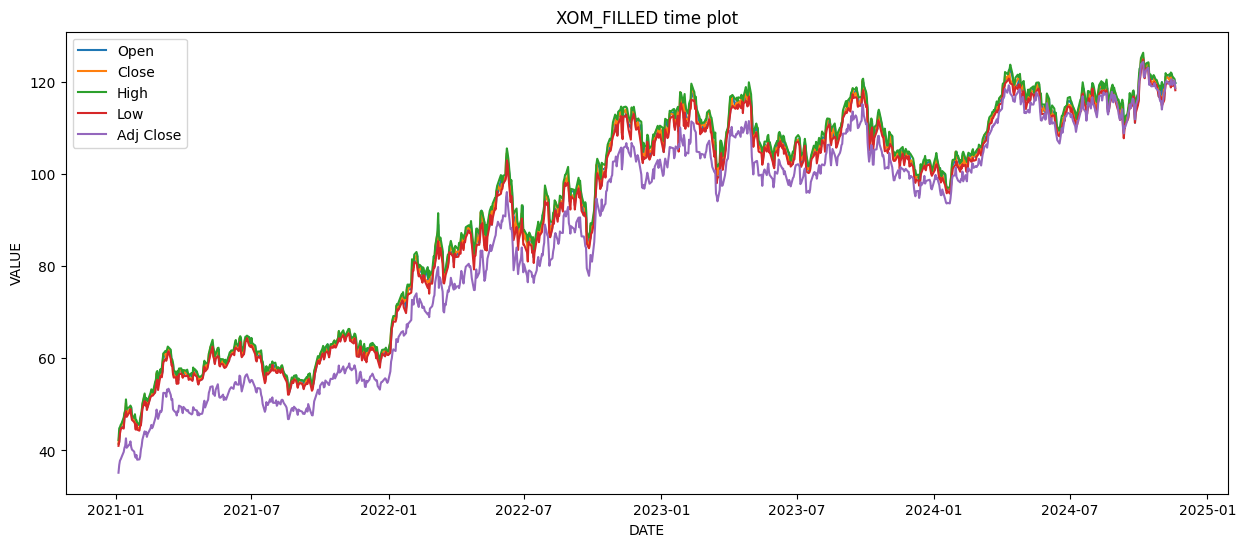

In [14]:
plot_ts(bp_filled)
plot_ts(shel_filled)
plot_ts(xom_filled)

<h3>Daily Return</h3>

We plot the ditribution of the daily returns for all three series:

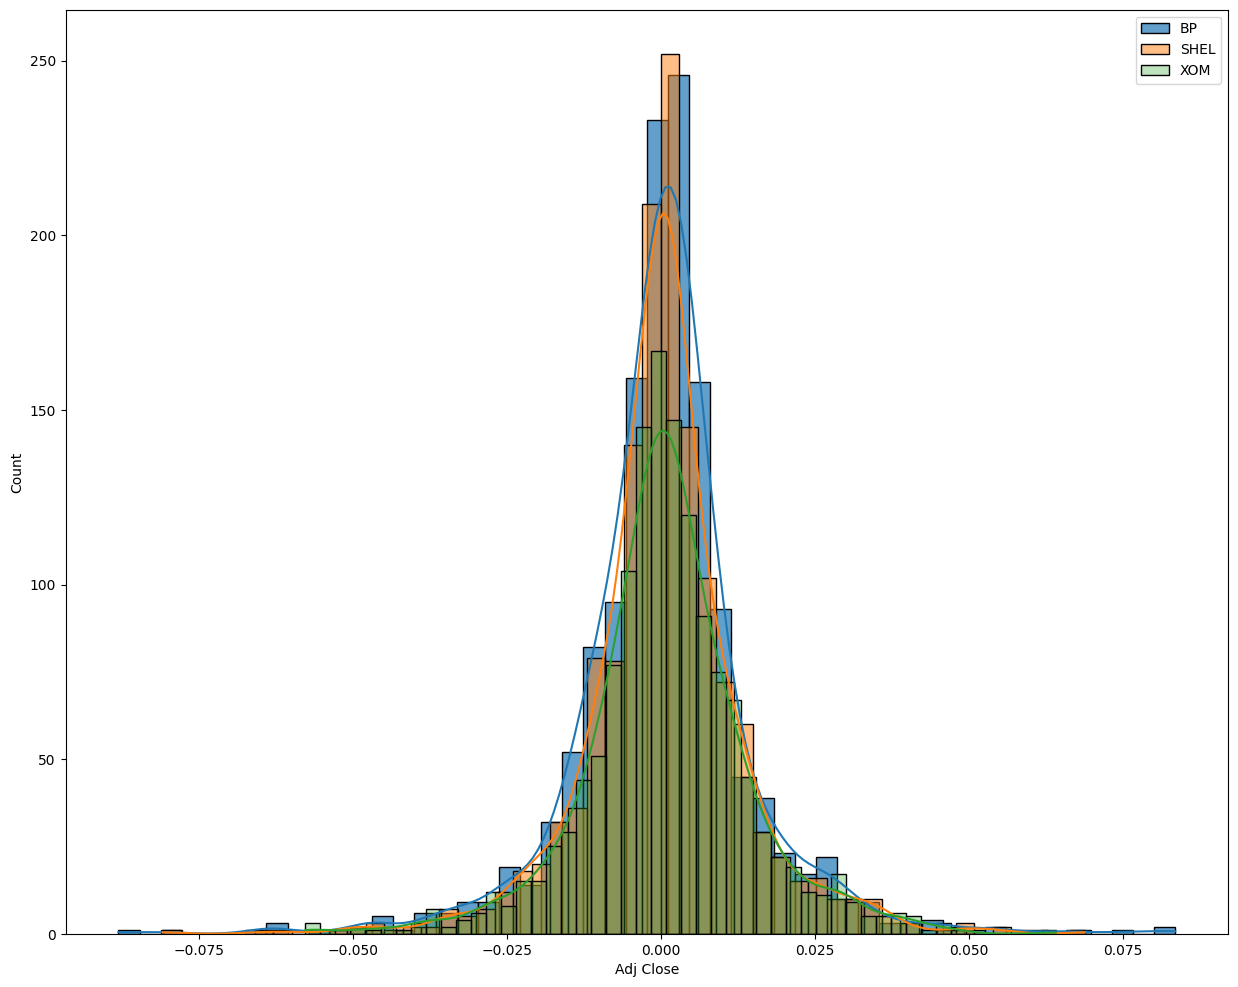

In [15]:
_, ax = plt.subplots(figsize = (15, 12))
sns.histplot(bp_filled['Adj Close'].pct_change(), bins = 50, alpha = 0.7, kde = True, label = 'BP', ax = ax)
sns.histplot(shel_filled['Adj Close'].pct_change(), bins = 50, alpha = 0.5, kde = True, label = 'SHEL', ax = ax)
sns.histplot(xom_filled['Adj Close'].pct_change(), bins = 50, alpha = 0.3, kde = True, label = 'XOM', ax = ax)
plt.legend()
plt.show()

For all the series the daily return is centered on 0, with most values between 2.5% and -2.5%.

<h3>Volatility</h3>

We compute a standard-deviation based volatility to describe the return tendency to vary in a specific period of time:

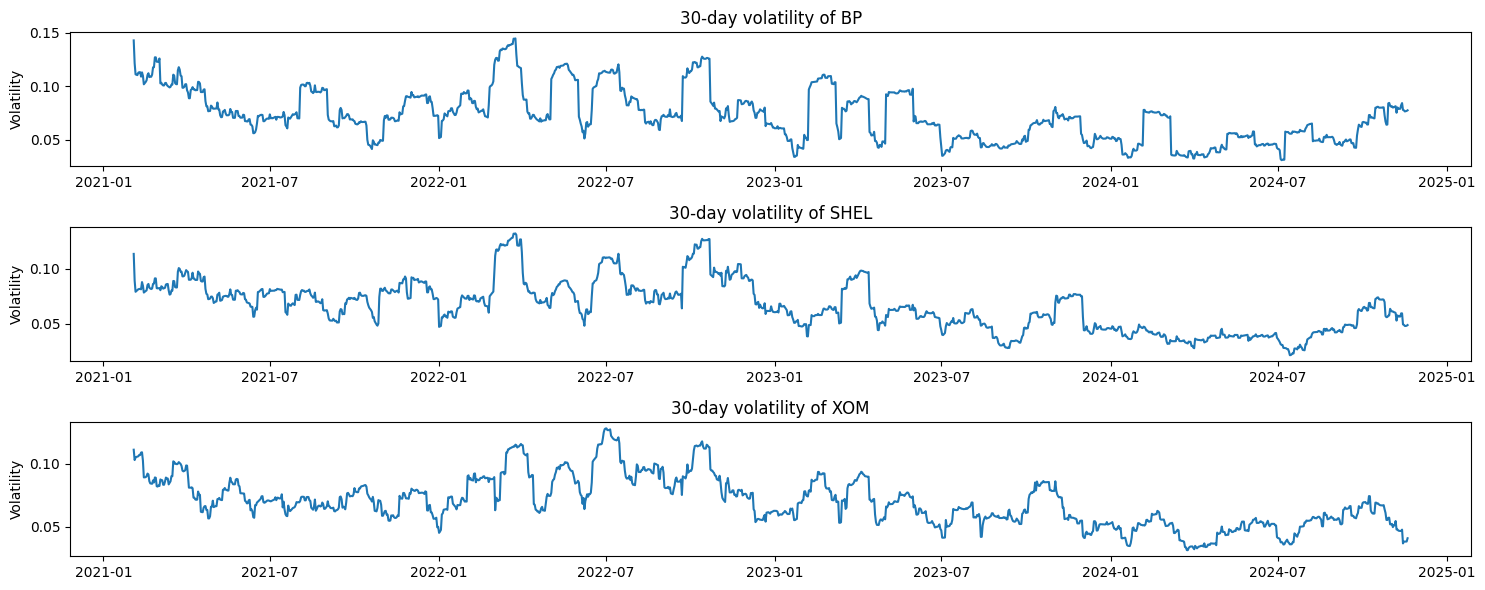

In [16]:
_, axes = plt.subplots(3, 1, figsize = (15, 6))
WINDOW = 30
for df, name, ax in zip([bp_filled, shel_filled, xom_filled], ['BP', 'SHEL', 'XOM'], axes.ravel()):
    volatility = df['Adj Close'].pct_change().rolling(window = WINDOW).std() * np.sqrt(WINDOW)
    sns.lineplot(x = df.index, y = volatility, ax = ax)
    ax.set_title(f'30-day volatility of {name}')
    ax.set_ylabel('Volatility')
plt.tight_layout()
plt.show()

In [17]:
print('check')

check


<h2>Single series forecasting</h2>

We focus our analysis to the data for *Adjusted Close Price* :

In [18]:
SERIES = 'Adj Close'
data_df = pd.DataFrame()
data_df['BP_aclose'] = bp_filled[SERIES]
data_df['SHEL_aclose'] = shel_filled[SERIES]
data_df['XOM_aclose'] = xom_filled[SERIES]
data_df.head()

,BP_aclose,SHEL_aclose,XOM_aclose
2021-01-04,17.184427,31.140999,35.163219
2021-01-05,18.463150,33.284489,36.857830
2021-01-06,19.312887,34.822952,37.798344
2021-01-07,19.725380,34.866161,38.094898
2021-01-08,20.129620,34.779736,38.518559


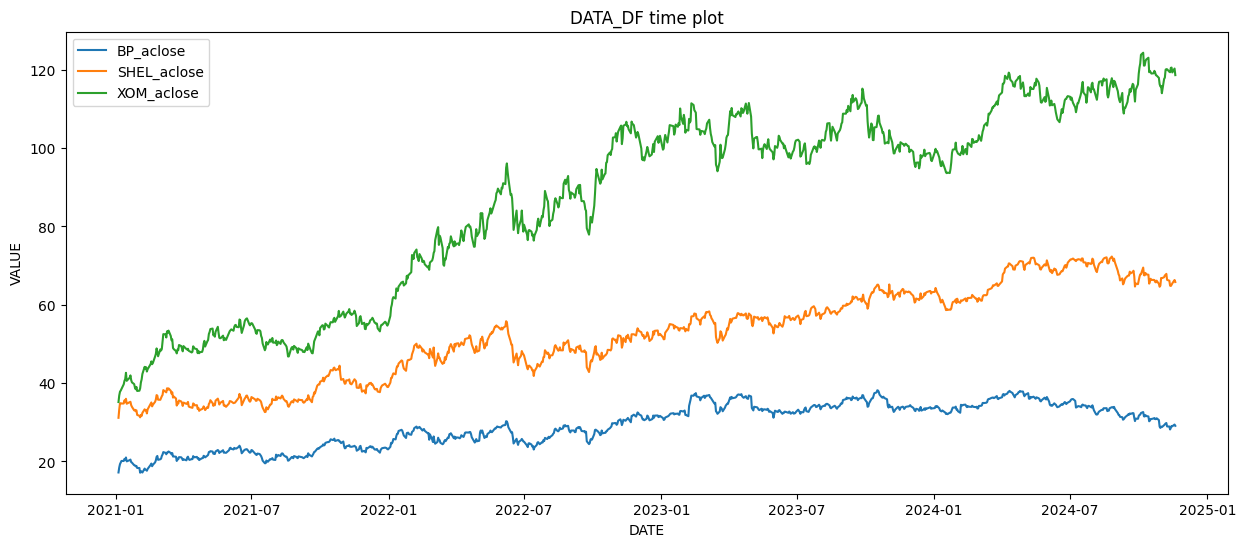

In [19]:
plot_ts(data_df, cols = ['BP_aclose', 'SHEL_aclose', 'XOM_aclose'])

<h3>Correlation</h3>

We check the correlation between the different time series:

<Axes: >

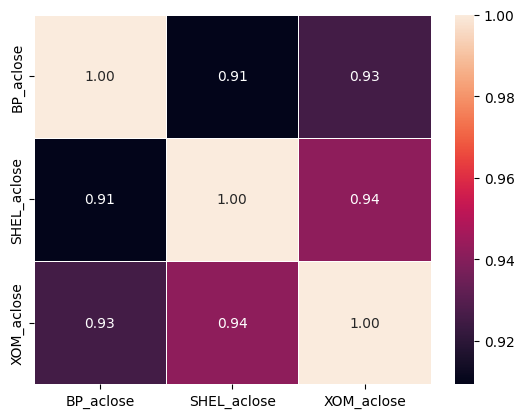

In [20]:
corr_matrix = data_df.corr()
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', linewidth = 0.5)

The series are all highly correlated, as expected.

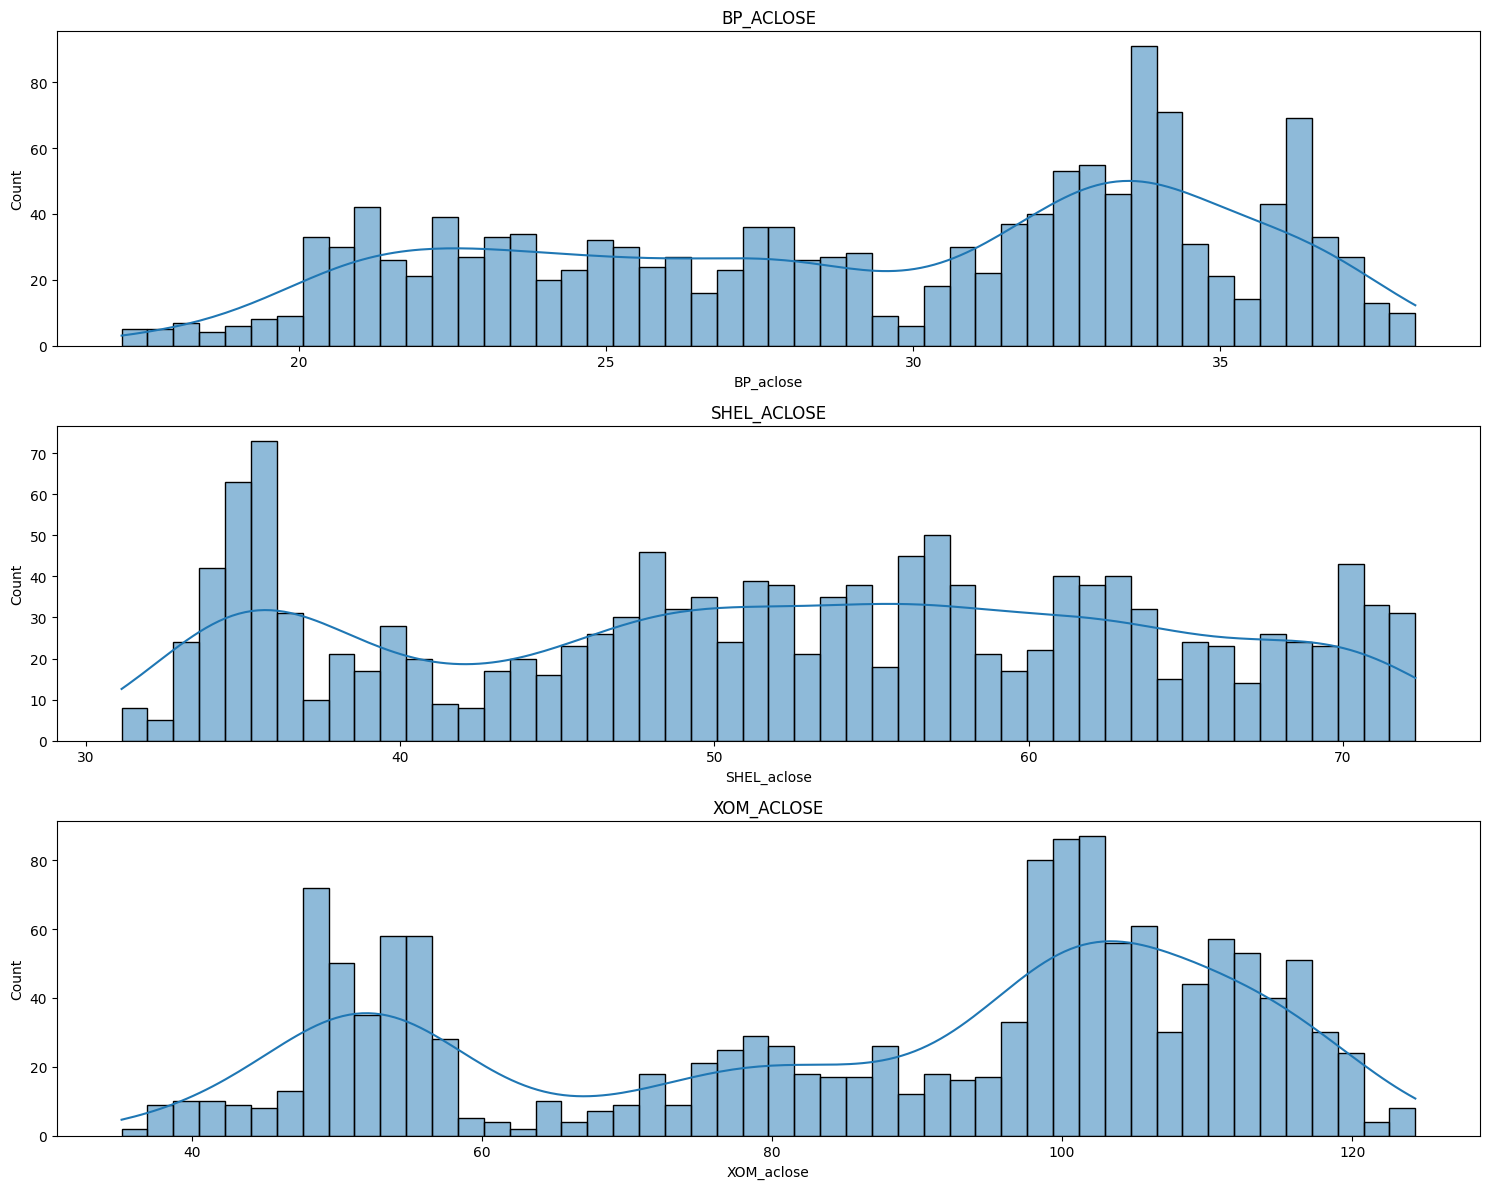

In [21]:
_, axes = plt.subplots(3, 1, figsize = (15, 12))
for ax, col in zip(axes, data_df.columns):
    sns.histplot(data = data_df, x = col, bins = 50, kde = True, ax = ax)
    ax.set_title(col.upper())
plt.tight_layout()
plt.show()

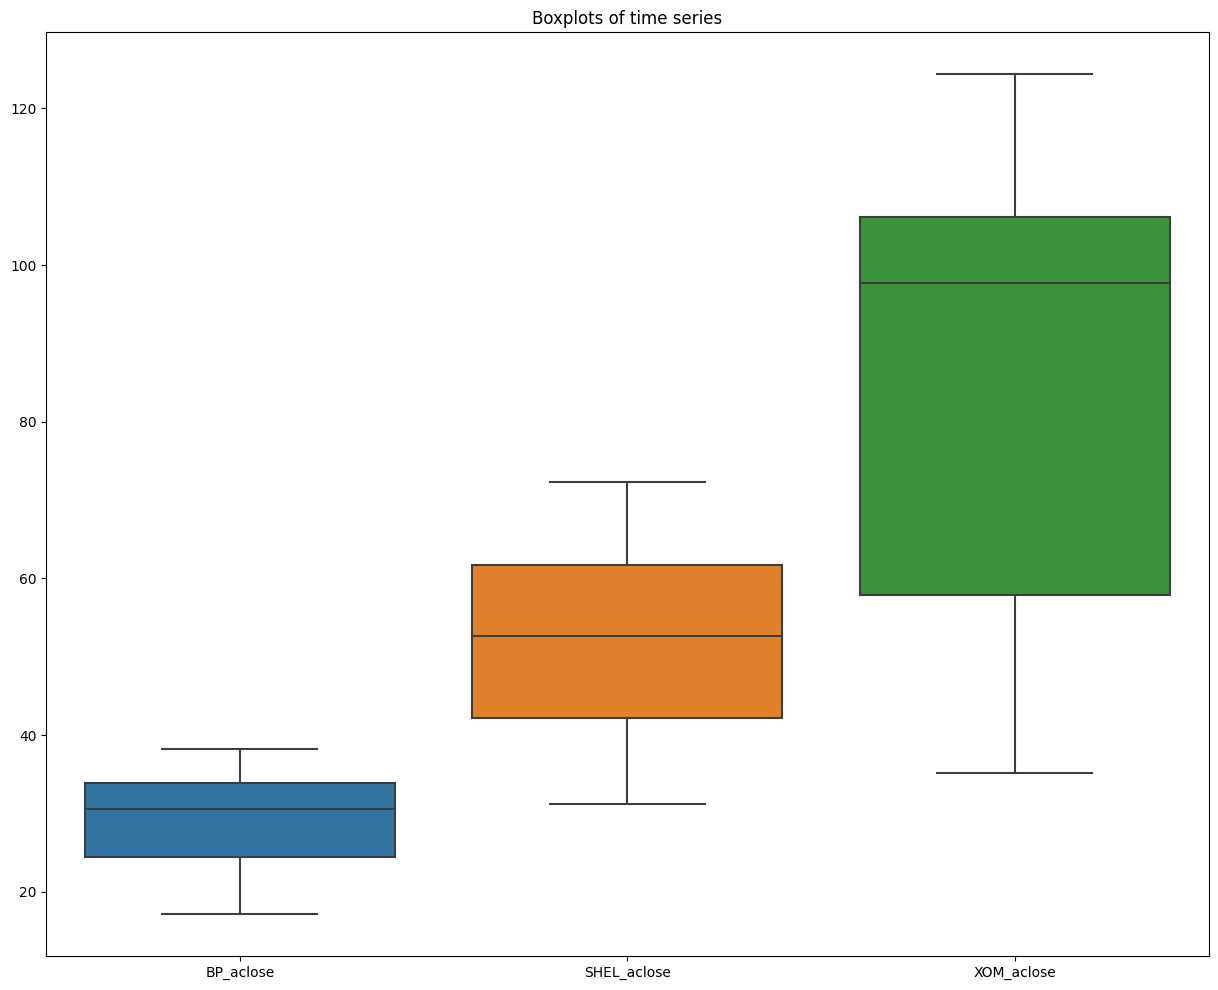

In [22]:
_, ax = plt.subplots(figsize = (15, 12))
sns.boxplot(data = data_df, ax = ax)
ax.set_title('Boxplots of time series')
plt.show()

<h3>Moving Average</h3>

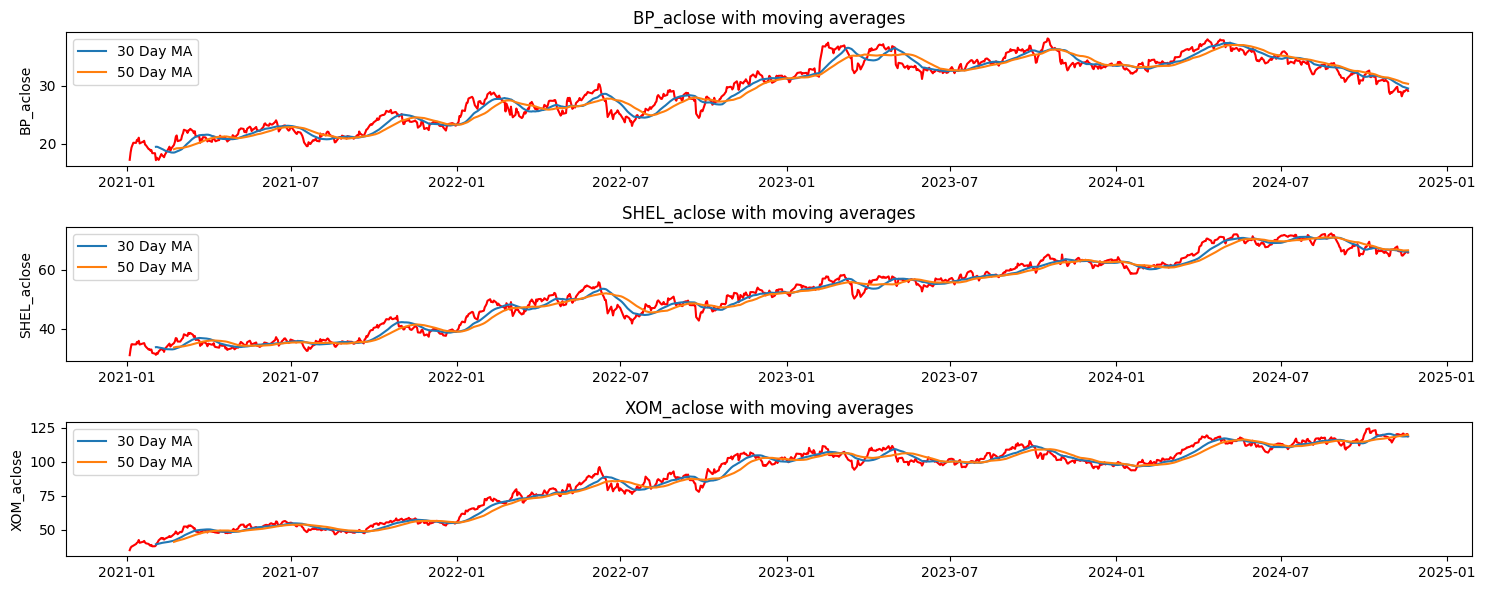

In [23]:
def plot_rolling_average(df, col, windows, ax = None):
    if ax is None:
        _, ax = plt.subplots(figsize = (15, 6))
    sns.lineplot(x = df.index, y = df[col], color = 'red', ax = ax)
    for window in windows:
        roll_avg = df[col].rolling(window).mean()
        sns.lineplot(x = df.index, y = roll_avg, label = f'{window} Day MA',ax = ax)
    ax.set_title(f'{col} with moving averages')
    plt.legend()


_, axes = plt.subplots(3, 1, figsize = (15, 6))
for ax, col in zip(axes, list(data_df.columns)):
    plot_rolling_average(data_df, col, windows = [30, 50], ax = ax)
plt.tight_layout()
plt.show()

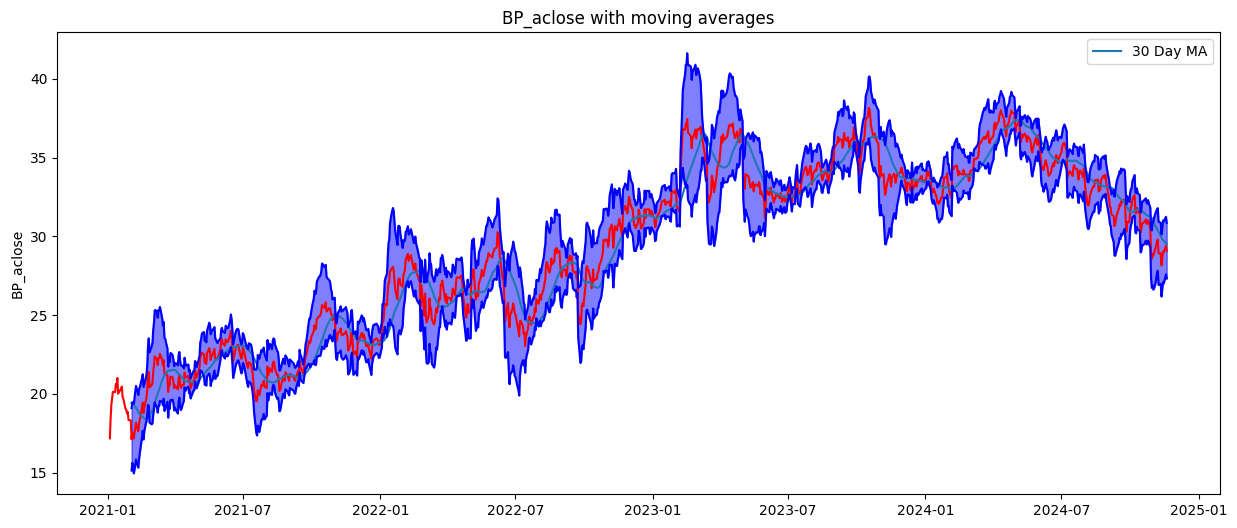

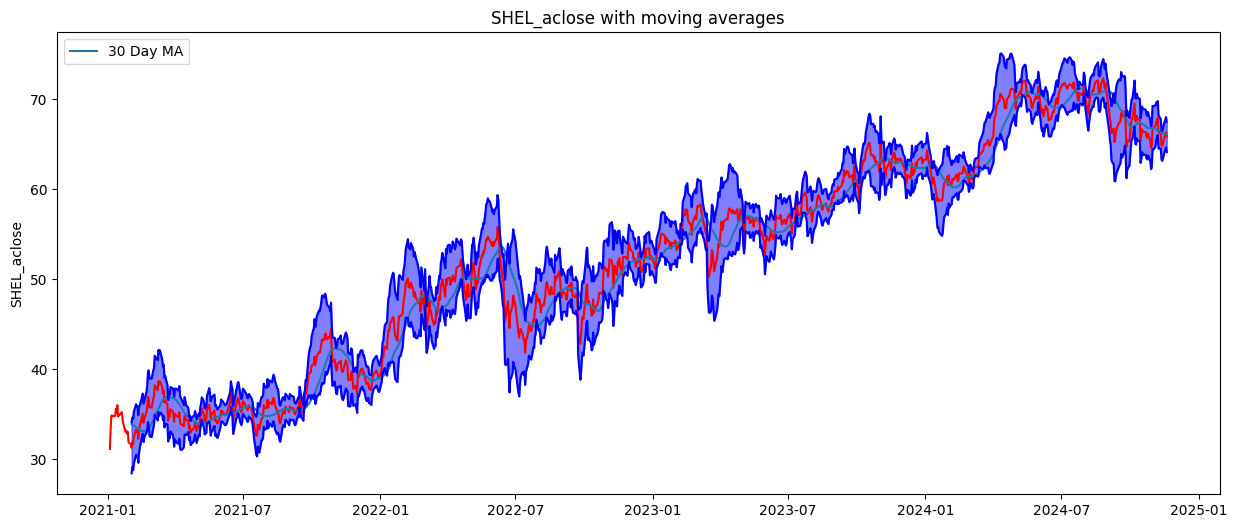

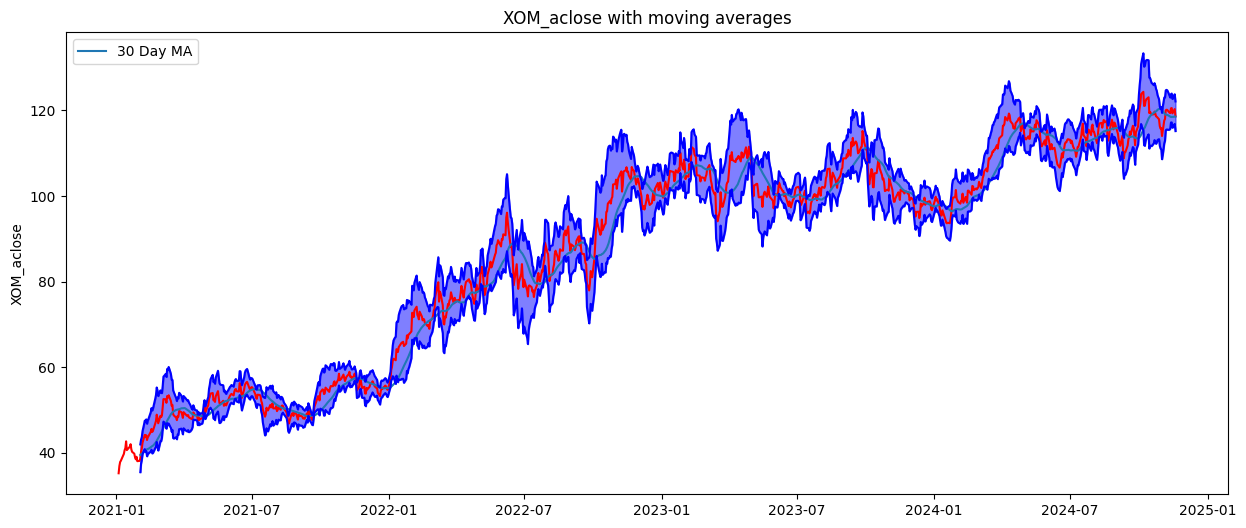

In [24]:
def plot_bollinger_bands(df, col, window, ax = None):
    if ax is None:
        _, ax = plt.subplots(figsize = (15,6))
    roll_avg = df[col].rolling(window).mean()
    roll_avg_lower = df[col] - df[col].rolling(window).std() * 2
    roll_avg_upper = df[col] + df[col].rolling(window).std() * 2
    sns.lineplot(x = df.index, y = df[col], color = 'red', ax = ax)
    sns.lineplot(x = df.index, y = roll_avg, label = f'{window} Day MA', ax = ax)
    sns.lineplot(x = df.index, y = roll_avg_lower, color = 'blue', ax = ax)
    sns.lineplot(x = df.index, y = roll_avg_upper, color = 'blue', ax = ax)
    plt.fill_between(x = df.index, y1 = roll_avg_lower, y2 = roll_avg_upper, color = 'blue', alpha = 0.5)
    ax.set_title(f'{col} with moving averages')
    plt.show()

for ax, col in zip(axes, list(data_df.columns)):
    plot_bollinger_bands(data_df, col, window = 30)

<h3>Decomposition</h3>

We decompose the time series to distinguish between trend and seasonal component:

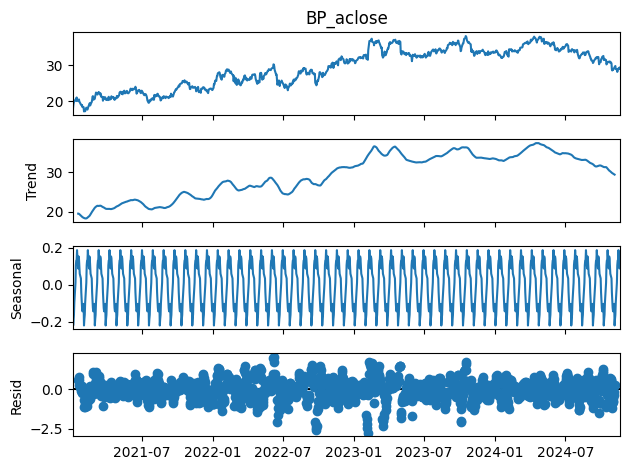

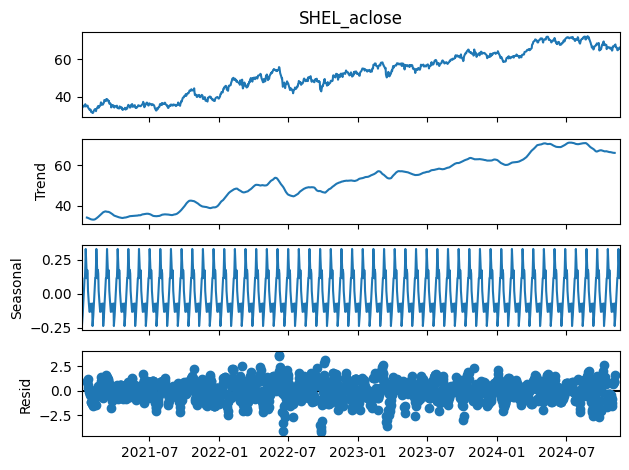

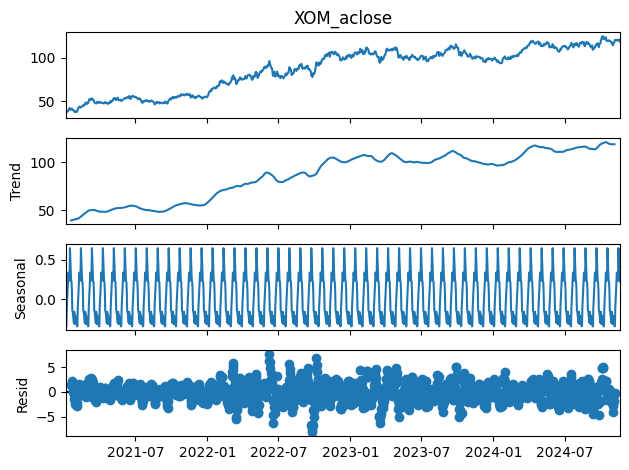

In [25]:
for col, ax in zip(data_df.columns, axes.ravel()):
    result = seasonal_decompose(data_df[col], model = 'additive', period = 28)
    ax = result.plot()
    plt.show()

It's clear that the seasonal component is negligible w.r.t. the trend which define the significant contribution to the stock price.

<h3>Stationarity check</h3>

We perform the Augmented Dickey-Fuller unit root test to check for stationarity, in case the time series are not stationary we check how many differencing are needed to achieve it:

In [26]:
def check_stationarity(df, col):
    results = adfuller(df[col]) 
    results_Series = pd.Series(results[0:4], index = ['ADF', 'p-value', '# Lags', '# obs'], name = 'ADF Test results')
    results_Series = pd.concat([results_Series, pd.Series(results[4])], axis = 0)
    print(results_Series.to_string())
    if results[1] <= 0.05:
        print('\nTime series is stationary.')
    else:
        pval = results[1]
        d = 0
        diffed_ts = df[col]
        while(pval > 0.05):
            diffed_ts = diffed_ts.diff().dropna()
            pval = adfuller(diffed_ts)[1]
            d += 1
        print(f'\nTime series becomes stationary after {d} differentiation.')

for col in data_df.columns:
    sep(col)
    check_stationarity(data_df, col)

------------------------------------------------------------
                    BP_ACLOSE
------------------------------------------------------------
ADF          -2.113578
p-value       0.239090
# Lags        1.000000
# obs      1414.000000
1%           -3.434983
5%           -2.863586
10%          -2.567859

Time series becomes stationary after 1 differentiation.
------------------------------------------------------------
                  SHEL_ACLOSE
------------------------------------------------------------
ADF          -1.353600
p-value       0.604308
# Lags        1.000000
# obs      1414.000000
1%           -3.434983
5%           -2.863586
10%          -2.567859

Time series becomes stationary after 1 differentiation.
------------------------------------------------------------
                    XOM_ACLOSE
------------------------------------------------------------
ADF          -1.605851
p-value       0.480654
# Lags        1.000000
# obs      1414.000000
1%           -3

As the time series plots suggested, they're all not stationary, however they become stationary after just one differencing.

<h3>(Partial) Autocorrelation</h3>

We first check the autocorrelation:

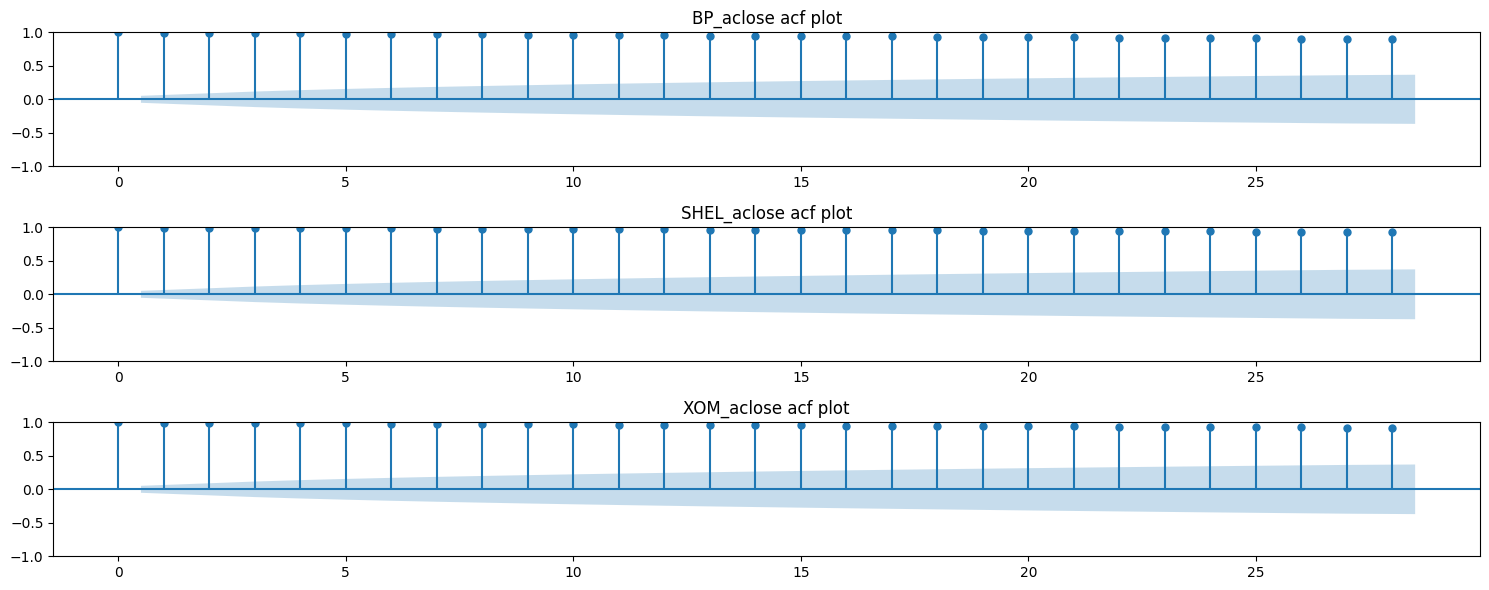

In [27]:
_, axes = plt.subplots(len(data_df.columns), 1, figsize = (15, 6))
for ax, col in zip(axes.ravel(), data_df.columns):
    plot_acf(data_df[col], lags = 28, ax = ax)
    ax.set_title(f'{col} acf plot')
plt.tight_layout()
plt.show()

The autocorrelation is significant even for large lags; however this can be easily explained by the time series having a strong trend component, to check the pure correlation between lagged values we check for partial autocorrelation:

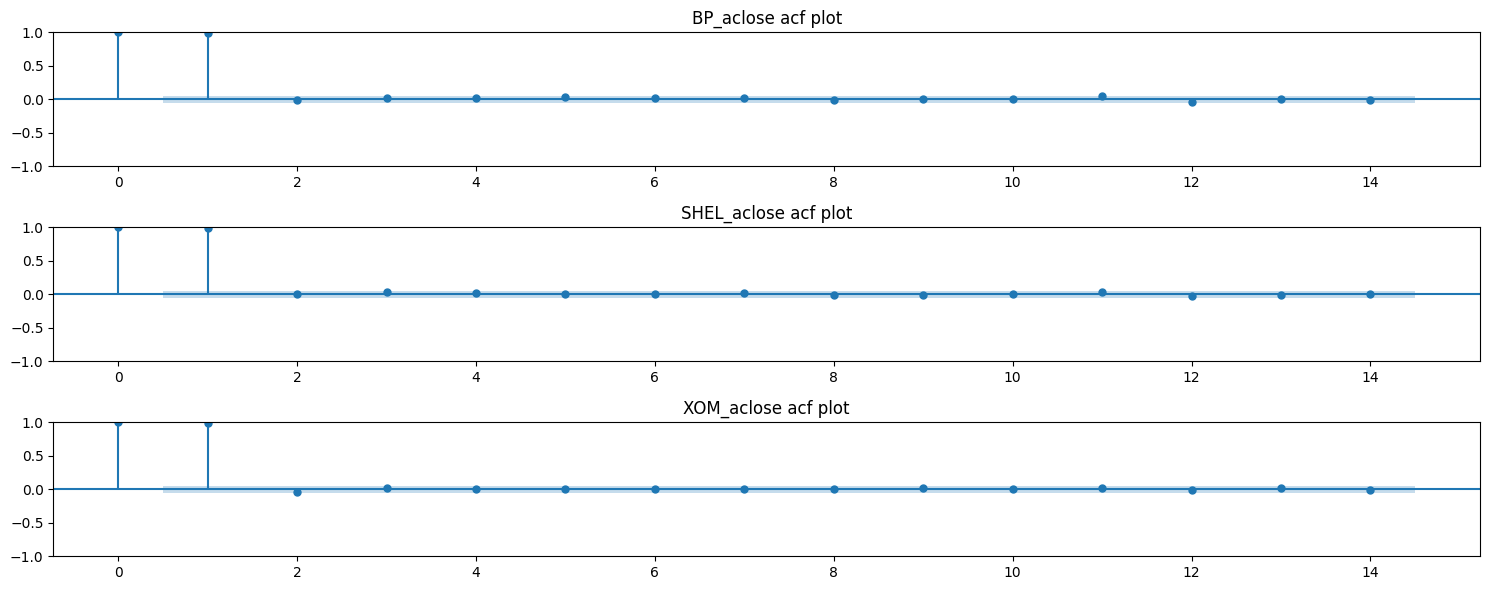

In [28]:
_, axes = plt.subplots(len(data_df.columns), 1, figsize = (15, 6))
for ax, col in zip(axes.ravel(), data_df.columns):
    plot_pacf(data_df[col], lags = 14, ax = ax)
    ax.set_title(f'{col} acf plot')
plt.tight_layout()
plt.show()

Here we see the correlation is evident for at most the first lag.

<h2>Modeling</h2>

We select the last 6 months of data for testing:

In [29]:
TEST_SIZE = 182
train = data_df.iloc[:-TEST_SIZE, :]
test = data_df.iloc[-TEST_SIZE:, :]
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1234 entries, 2021-01-04 to 2024-05-21
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BP_aclose    1234 non-null   float64
 1   SHEL_aclose  1234 non-null   float64
 2   XOM_aclose   1234 non-null   float64
dtypes: float64(3)
memory usage: 38.6 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2024-05-22 to 2024-11-19
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BP_aclose    182 non-null    float64
 1   SHEL_aclose  182 non-null    float64
 2   XOM_aclose   182 non-null    float64
dtypes: float64(3)
memory usage: 5.7 KB


None

<h3>Holt</h3>

We start modelling with Holt's Exponential Smoothing to be able to tackle with trend components, seasonal variations will be lost, but with the trend being the main contribution to the stock values it's a good baseline method:

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


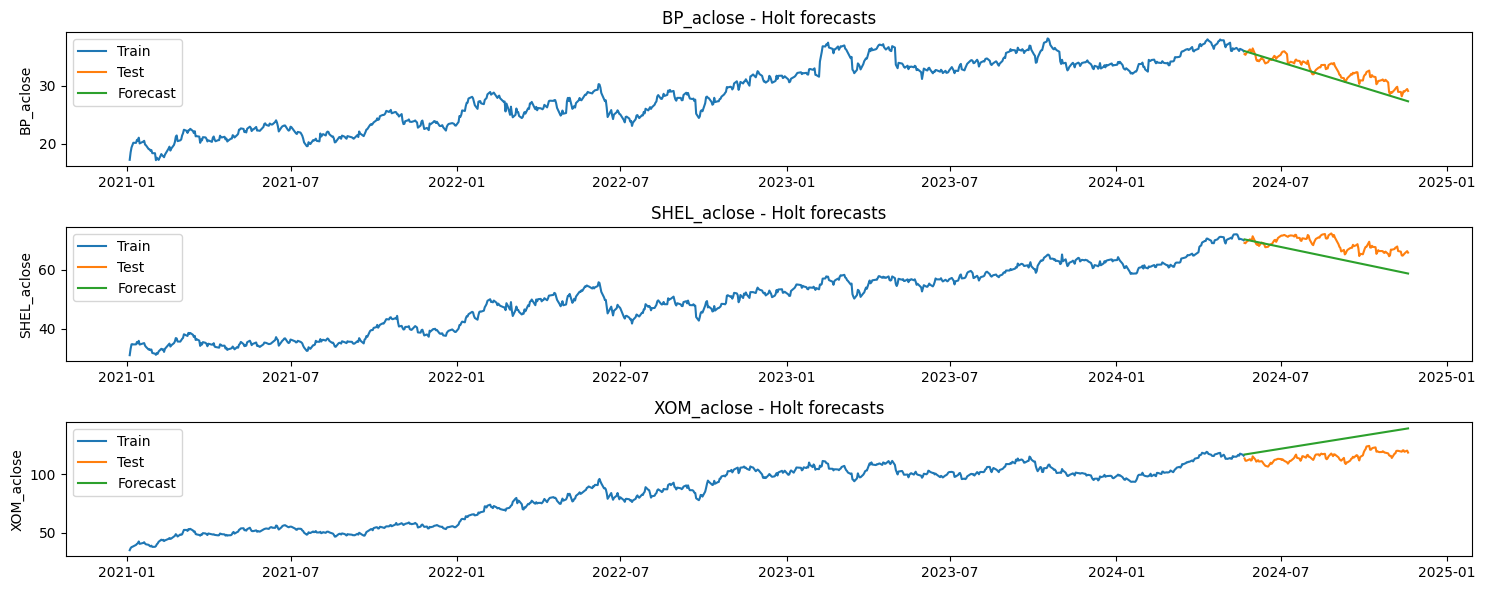

BP_ACLOSE MSE: 2.1715611535657433
SHEL_ACLOSE MSE: 24.587082236694307
XOM_ACLOSE MSE: 191.42744650883586



In [30]:
_, axes = plt.subplots(3, 1, figsize = (15, 6))
summary = ""
for col, ax in zip(data_df.columns, axes.ravel()):
    holt = Holt(np.asarray(train[col])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
    y_forecast = holt.forecast(len(test))
    summary += f"{col.upper()} MSE: " + str(mean_squared_error(test[col], y_forecast)) + '\n'
    sns.lineplot(x = train.index, y = train[col], label = 'Train', ax = ax)
    sns.lineplot(x = test.index, y = test[col], label = 'Test', ax = ax)
    sns.lineplot(x = test.index, y = y_forecast, label = 'Forecast', ax = ax)
    ax.set_title(f'{col} - Holt forecasts')
plt.legend()
plt.tight_layout()
plt.show()
print(summary)

<h3>Holt-Winter</h3>

As an extension of Holt's exponential smoothing we use the Winter's exponential smoothing, also called triple exponential smoothing since it's a combination of three smoothing methods to take into acoount seasonal components:

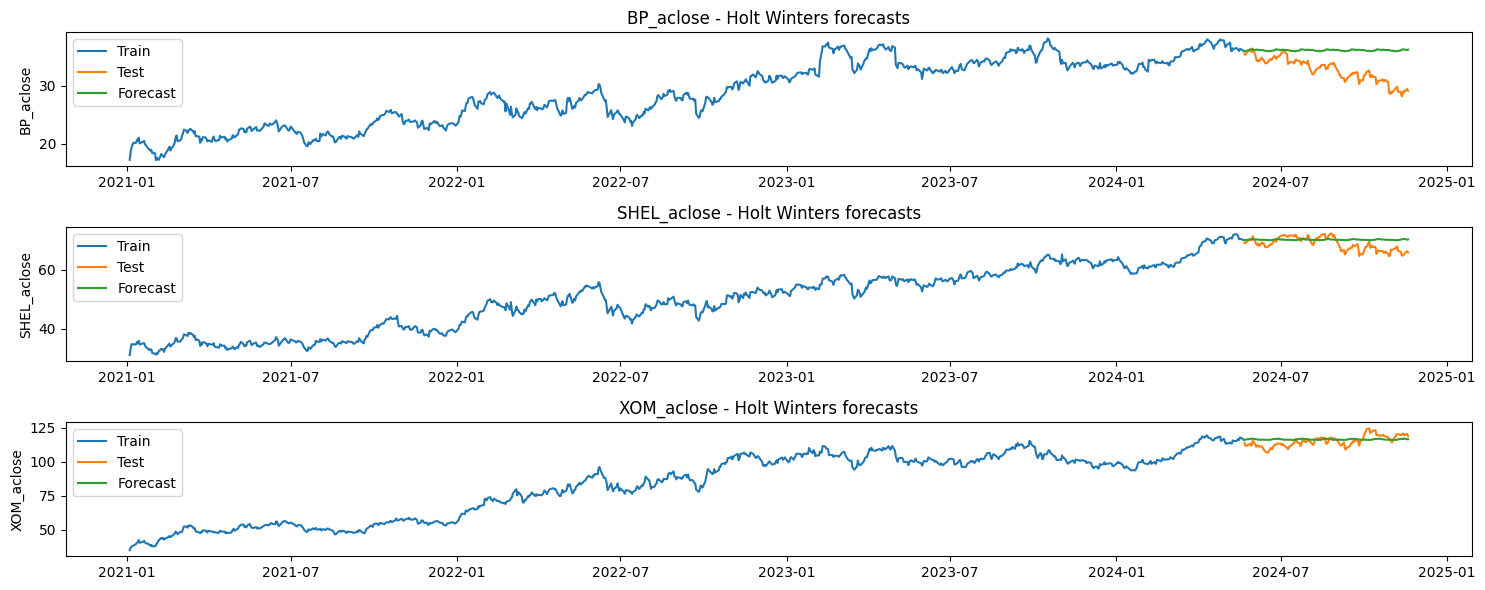

BP_ACLOSE MSE: 15.588171857558818
SHEL_ACLOSE MSE: 6.5961923980154
XOM_ACLOSE MSE: 16.02999092644667



In [31]:
_, axes = plt.subplots(3, 1, figsize = (15, 6))
summary = ""
for col, ax in zip(data_df.columns, axes.ravel()):
    holt_winters = ExponentialSmoothing(np.asarray(train[col]), seasonal_periods = 28, damped_trend = True, trend = 'add', seasonal = 'add').fit()
    y_forecast = holt_winters.forecast(len(test))
    summary += f"{col.upper()} MSE: " + str(mean_squared_error(test[col], y_forecast)) + '\n'
    sns.lineplot(x = train.index, y = train[col], label = 'Train', ax = ax)
    sns.lineplot(x = test.index, y = test[col], label = 'Test', ax = ax)
    sns.lineplot(x = test.index, y = y_forecast, label = 'Forecast', ax = ax)
    ax.set_title(f'{col} - Holt Winters forecasts')
plt.legend()
plt.tight_layout()
plt.show()
print(summary)

While the forecasting for BP are worse than the previous one, the Shell and Exxon stocks prediction are significantly improved.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


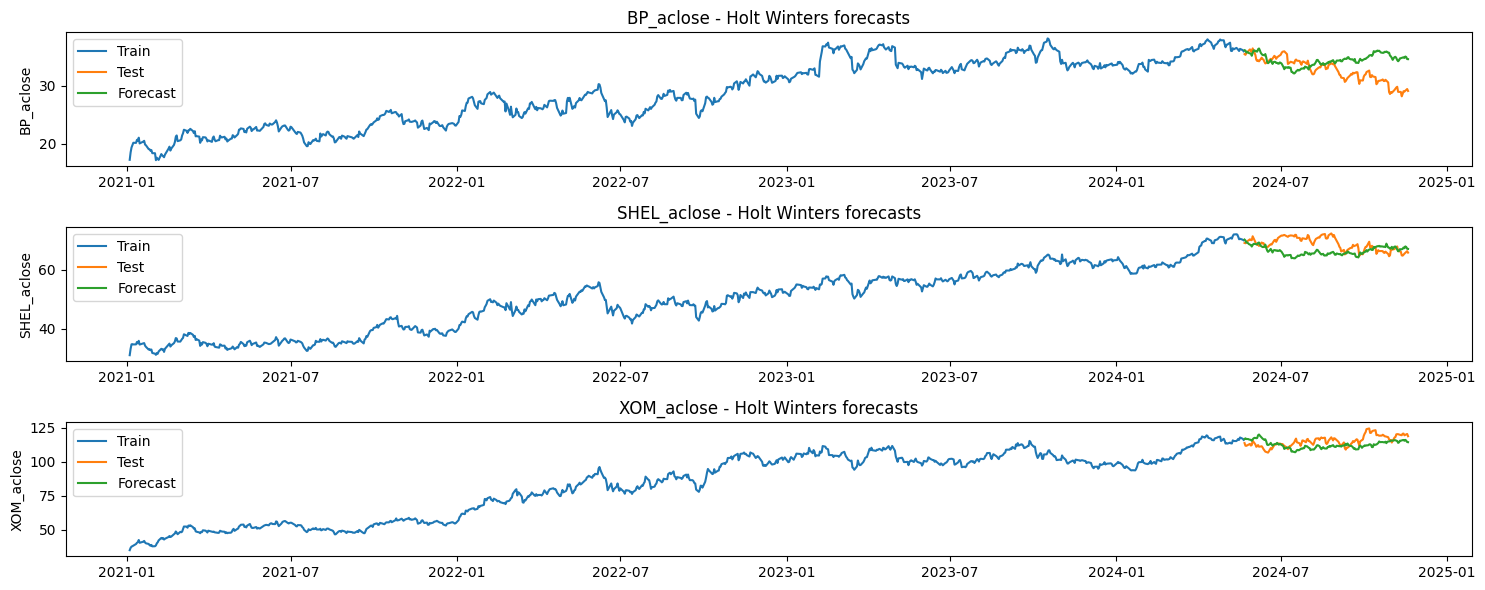

BP_ACLOSE MSE: 9.147518171067464
SHEL_ACLOSE MSE: 14.370873026084885
XOM_ACLOSE MSE: 28.838630909532014



In [32]:
_, axes = plt.subplots(3, 1, figsize = (15, 6))
summary = ""
for col, ax in zip(data_df.columns, axes.ravel()):
    holt_winters = ExponentialSmoothing(np.asarray(train[col]), seasonal_periods = 365, damped_trend = True, trend = 'add', seasonal = 'add').fit()
    y_forecast = holt_winters.forecast(len(test))
    summary += f"{col.upper()} MSE: " + str(mean_squared_error(test[col], y_forecast)) + '\n'
    #simulations = holt_winters.simulate(len(test), repetitions = 100, error = 'mul')
    #print(simulations.shape)
    sns.lineplot(x = train.index, y = train[col], label = 'Train', ax = ax)
    sns.lineplot(x = test.index, y = test[col], label = 'Test', ax = ax)
    sns.lineplot(x = test.index, y = y_forecast, label = 'Forecast', ax = ax)
    #simulations.plot(ax = ax, style = "-", alpha = 0.05, color = "grey", legend = False)
    ax.set_title(f'{col} - Holt Winters forecasts')
plt.legend()
plt.tight_layout()
plt.show()
print(summary)

<h3>ARIMA</h3>

To perform a fit we need to adjust three parameters for the Auto Regressive (AR), Differencing (I) and Moving Averages (MA) components of the ARIMA model, to do so we perform a grid paramters search:

In [33]:
arima_params = {'p' : list(range(1,6)), 'd' : [1], 'q' : list(range(1,6))}

def arima_best_fit(data, params):
    keys, values = zip(*params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    best_params = None
    best_score = 1_000_000
    start = time.time()
    for param_dict in permutations_dicts:
        model = ARIMA(data, order = (param_dict['p'], param_dict['d'], param_dict['q']))
        arima_fit = model.fit()
        score = arima_fit.aic
        if score < best_score:
            best_score = score
            best_params = param_dict
    stop = time.time()
    print('BEST SCORE: ', best_score)
    print('BEST PARAMS: ', best_params)
    print('TIME: ', np.round((stop - start), 2))
    
for col in train.columns:
    sep(col)
    arima_best_fit(train[col], arima_params)

------------------------------------------------------------
                    BP_ACLOSE
------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

BEST SCORE:  1227.9755651878702
BEST PARAMS:  {'p': 2, 'd': 1, 'q': 2}
TIME:  32.55
------------------------------------------------------------
                  SHEL_ACLOSE
------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

BEST SCORE:  2354.4940881522543
BEST PARAMS:  {'p': 2, 'd': 1, 'q': 3}
TIME:  34.9
------------------------------------------------------------
                    XOM_ACLOSE
------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

BEST SCORE:  3769.7819663481705
BEST PARAMS:  {'p': 2, 'd': 1, 'q': 3}
TIME:  31.34


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The forecasting results with the best parameters are as follow:

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


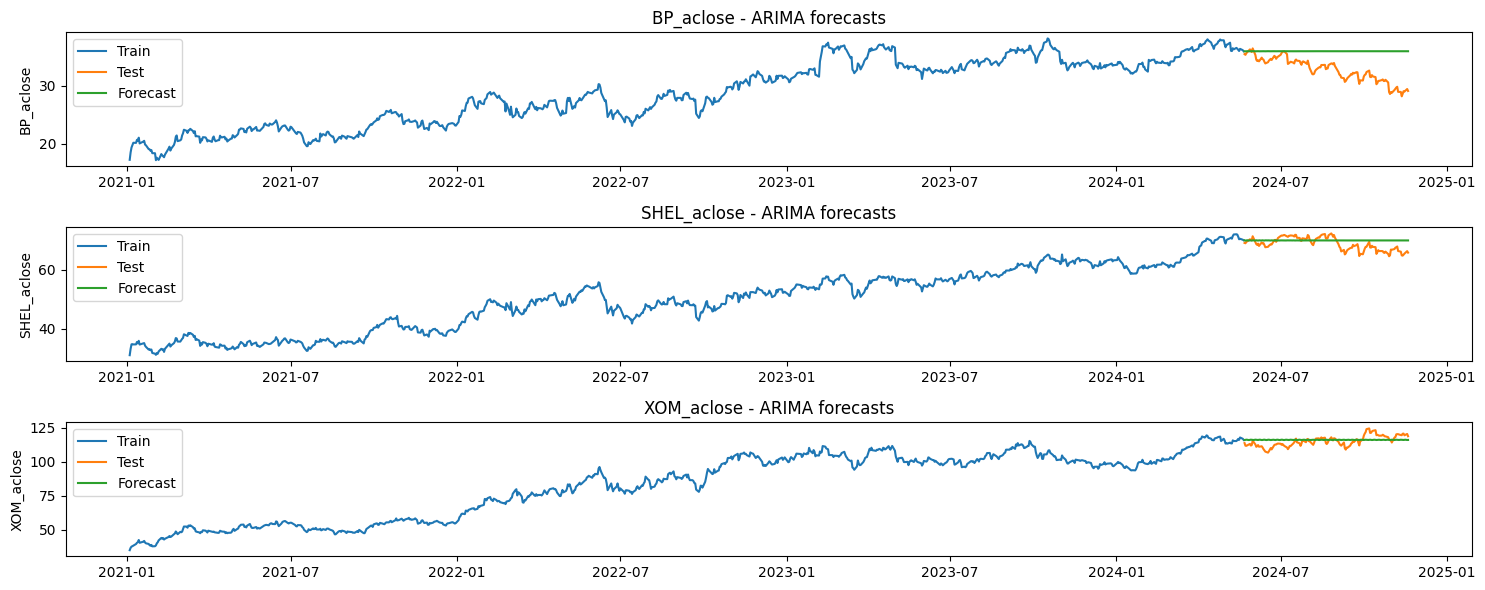

BP_ACLOSE MSE: 14.505451136656964
SHEL_ACLOSE MSE: 5.9653566588616105
XOM_ACLOSE MSE: 15.458529035364366



In [34]:
orders = [(2, 1, 2), (2, 1, 3), (2, 1, 3)]
_, axes = plt.subplots(3, 1, figsize = (15, 6))
summary = ""
for col, ax, order in zip(data_df.columns, axes.ravel(), orders):
    model = ARIMA(train[col], order = order)
    arima_fit = model.fit()
    y_forecast = arima_fit.forecast(len(test))
    summary += f"{col.upper()} MSE: " + str(mean_squared_error(test[col], y_forecast)) + '\n'
    sns.lineplot(x = train.index, y = train[col], label = 'Train', ax = ax)
    sns.lineplot(x = test.index, y = test[col], label = 'Test', ax = ax)
    sns.lineplot(x = test.index, y = y_forecast, label = 'Forecast', ax = ax)
    ax.set_title(f'{col} - ARIMA forecasts')
plt.legend()
plt.tight_layout()
plt.show()
print(summary)